Student id: 24206493

#### Q1. Load the dataset into a Python notebook and rank the following models in terms of accuracy using cross-validation:
    - k-Nearest Neighbour: default parameters
    - k-Nearest Neighbour: k = 100
    - Decision Tree: default parameters
    - Decision Tree: max depth = 10
    - Gaussian Naive Bayes: default parameters

Comment on the stability of this ranking.

In [275]:
#importing all the relevant libraries

import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold

I am starting by loading the dataset using pandas and verifying that we have our dataframe for further processing.

In [276]:
df = pd.read_csv('diabetes_70k.csv')
df.shape

(70692, 22)

In [277]:
df.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,class
0,1,0,1,31,1,0,0,0,0,0,...,0,1,5,0,0,0,10,4,7,0
1,1,1,1,27,0,0,0,1,0,1,...,0,2,0,0,0,0,11,5,7,0
2,0,1,1,32,1,0,1,0,1,1,...,0,5,0,15,1,0,10,5,5,0
3,0,1,1,23,1,1,0,1,1,0,...,0,2,0,3,0,0,12,5,8,0
4,0,1,1,37,1,0,0,0,0,1,...,0,3,21,14,1,0,6,5,1,0


In [278]:
df["class"].unique() 

array([0, 1])

The website of which dataset is part said there are three classes (Pre-diabetic, Diabetic and Healthy) so I wanted to check how they are represented. However the csv file has only 0's and 1's so it needs no preprocessing and makes my job easy.
Next step, putting all the label values in a seperate series.

In [279]:
y = df.pop('class').values

Scaling is quite crucial for kNNs as they depend on distances to classify and outliers may get disproportionate advantage in this case. Since it doesnt effect the outcomes of DTrees and NB, so I have decided to use it throughout as a best practice.

In [280]:
Xraw = df.values
scaler = StandardScaler()
X = scaler.fit_transform(Xraw)

#### Mean accuracy metrics for the five classifiers using 5 fold X-Val for the full set 

On multiple runs, I observed that the decision tree was giving me a hard time, fluctuating its values by approx 1% so I decided to set a random state to ensure reproducibility of my results and further analysis.

In [281]:
models = [ KNeighborsClassifier() , KNeighborsClassifier(n_neighbors= 100),
          DecisionTreeClassifier(random_state=0), DecisionTreeClassifier(max_depth = 10, random_state=0), GaussianNB() ]

for i in models:
    kf = KFold(n_splits=5, shuffle = True, random_state=1) # needed to ensure shuffling
    scores = cross_val_score(i, X, y, cv=kf)
    #print(scores)
    print("5 x {0} : {1:.2f}, {2:.4f}".format(i, scores.mean(), scores.std())) 

5 x KNeighborsClassifier() : 0.71, 0.0029
5 x KNeighborsClassifier(n_neighbors=100) : 0.74, 0.0045
5 x DecisionTreeClassifier(random_state=0) : 0.65, 0.0058
5 x DecisionTreeClassifier(max_depth=10, random_state=0) : 0.73, 0.0045
5 x GaussianNB() : 0.72, 0.0033


Following is the order of ranking in terms of the accuracy of the given 5 classifiers using cross-valdation:
1. kNN(n_neighbours = 100) at 74%
2. Decision Tree (max_depth=10) at 73%
3. GaussianNB with default values at 72%
4. kNN with default values at 71%
5. Decision tree with default values at 65%

The kNN classifier with 100 neighbours (74%) performs better on accuracy than the one with the default setting(71%) that works on the votes of only 5 neighbours. The similar trend could be seen with Decision Tree where specifying max depth increases the accuracy by about 9 percent. This could mean that under default conditions, decision tree creates a large tree trying to over-fit the training data which decreases the overall generalisation accuracy on the test data. The Naive Bayes classifier with the default values provides a mean accuracy of 72% ranking 3rd. The standard deviation values for all classifiers are less than 0.01,  being insignificant to comment on.

#### Stability Analysis for X-Val accuracy scores across classifiers

To probe into the stability of the ranking, I am considering two cases:
1. Running the X-Val tests 50 times and shuffling the train and test sets randomly to measure accuracy over these 50 iterations
2. Checking the variation in accuracy for different sizes of folds.

I plot the accuracy graphs of all the 5 classifiers to check the stability trends.

#### Case 1

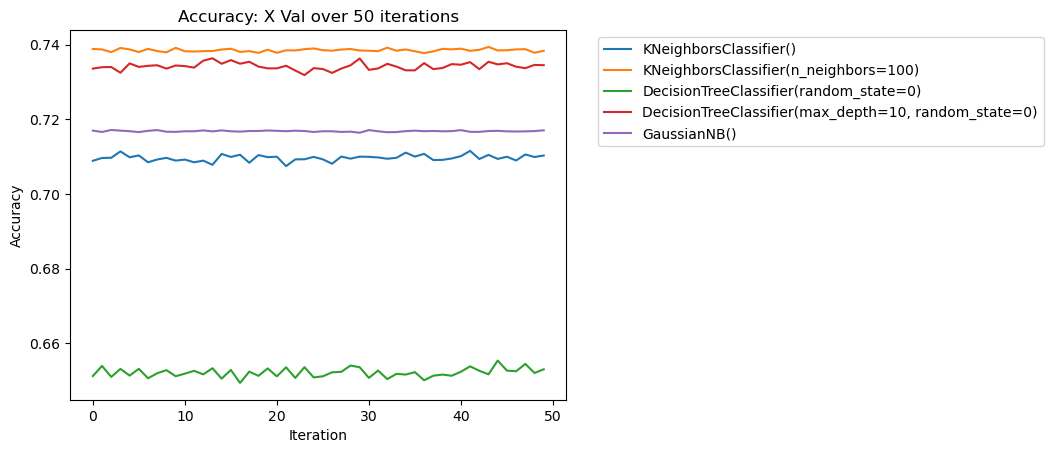

In [282]:
import matplotlib.pyplot as plt
%matplotlib inline
xv = {}
reps = 50  
for i in models:
    xv_list = []
    for j in range(reps):
        kf = KFold(n_splits=5, shuffle = True, random_state=j) # needed to ensure shuffling
        scores = cross_val_score(i, X, y, cv=kf)
        xv_list.append(scores.mean())
        #print(xv_list)
    xv[i] = xv_list
acc_values = pd.DataFrame(xv, columns = xv.keys())
acc_values

ax = acc_values.plot()
ax.set_xlabel("Iteration")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy: X Val over 50 iterations")
ax.legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

The rankings seem largely stable over 50 iterations with shuffled test and train sets + random. This is also possible because X-val averages the accuracy scores of 5 folds each time so the variance is not significant. In the next case, I am changing the fold sizes to see if that has any effect on the stability of the accuracy scores.

#### Case 2

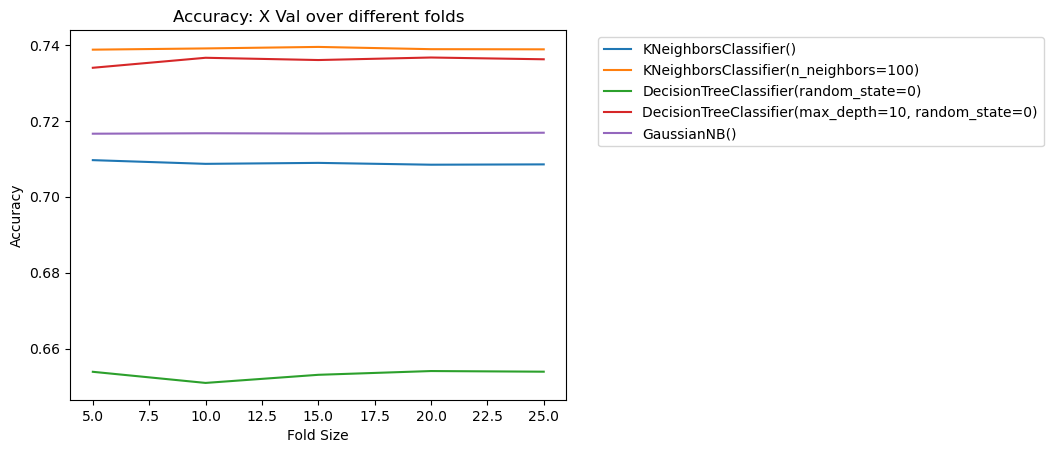

In [283]:
xv = {} 
for i in models:
    xv_list = []
    cv_num = [5, 10, 15, 20, 25]
    for j in cv_num:
        kf = KFold(n_splits=j,shuffle = True, random_state=1)
        scores = cross_val_score(i, X, y, cv=kf)   
        xv_list.append(scores.mean())
        #print(xv_list)
    xv[i] = xv_list
acc_values = pd.DataFrame(xv, columns = xv.keys(), index = cv_num)
acc_values
ax = acc_values.plot()
ax.set_xlabel("Fold Size")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy: X Val over different folds")
ax.legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Yet again, the ranking trend for X val accuracy scores stays the consistent with insignificant deviations across different folds.

#### Q2. Repeat the test above but using hold-out testing (2:1 split). Again comment on the stability of the ranking.

In [285]:
hold_out = {}
for i in models:
    X_train, X_test, y_train, y_test = train_test_split(X, y,  train_size = 2/3 ,random_state = 1)
    y_pred = i.fit(X_train, y_train).predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    hold_out[i] = round(acc, 2)
print(hold_out)

{KNeighborsClassifier(): 0.71, KNeighborsClassifier(n_neighbors=100): 0.74, DecisionTreeClassifier(random_state=0): 0.66, DecisionTreeClassifier(max_depth=10, random_state=0): 0.74, GaussianNB(): 0.72}


Following is the order of ranking in terms of the accuracy of the given 5 classifiers using hold out testing:
1. kNN(n_neighbours = 100) & Decision Tree (max_depth=10) at 74%
2. GaussianNB with default values at 72%
3. kNN with default values at 71%
4. Decision tree with default values at 66%

The results are quite similar to X-val testing here. However, it will be interesting to check the stability of these rankings.

#### Stability Analysis for Hold-Out accuracy scores across classifiers

Considering the two cases to capture the H-O accuracy trends:
1. Running the HO tests 50 times and shuffling the train and test sets randomly to measure accuracy over these 50 iterations while the split stays 2:1
2. Checking the variation in accuracy for different sizes of train-test splits

#### Case 1

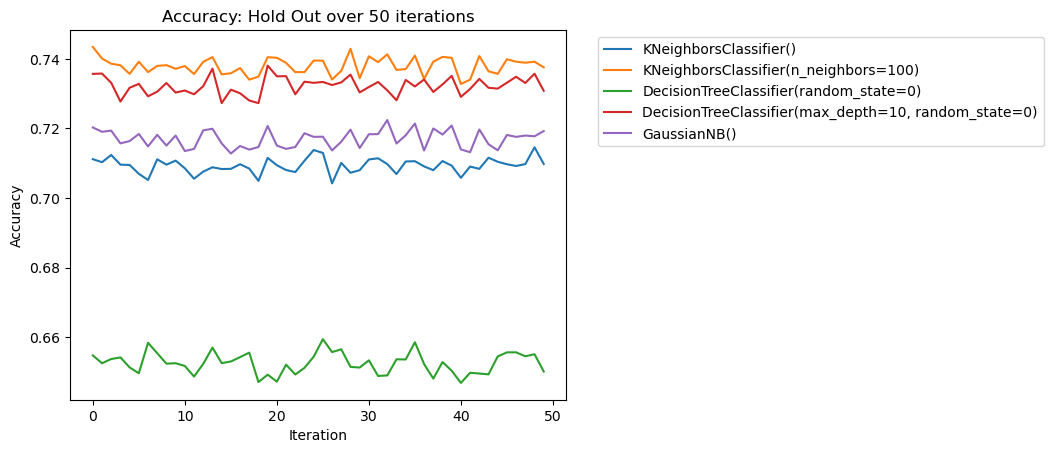

In [286]:
h_out = {}
reps = 50  
for i in models:
    ho_list = []
    for j in range(reps):
        X_train, X_test, y_train, y_test = train_test_split(X, y,  train_size = 0.66, random_state = j)
        y_pred = i.fit(X_train, y_train).predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        ho_list.append(acc)
    h_out[i] = ho_list
acc_values = pd.DataFrame(h_out, columns = h_out.keys())
acc_values
ax = acc_values.plot()
ax.set_xlabel("Iteration")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy: Hold Out over 50 iterations")
ax.legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

The results of Case 1 for Hold out show that the ranking trend remains the same as XVal, however, the overall variance is higher. This could be because the moderating effect of the averaging that Xval is no longer applicable here.

#### Case 2

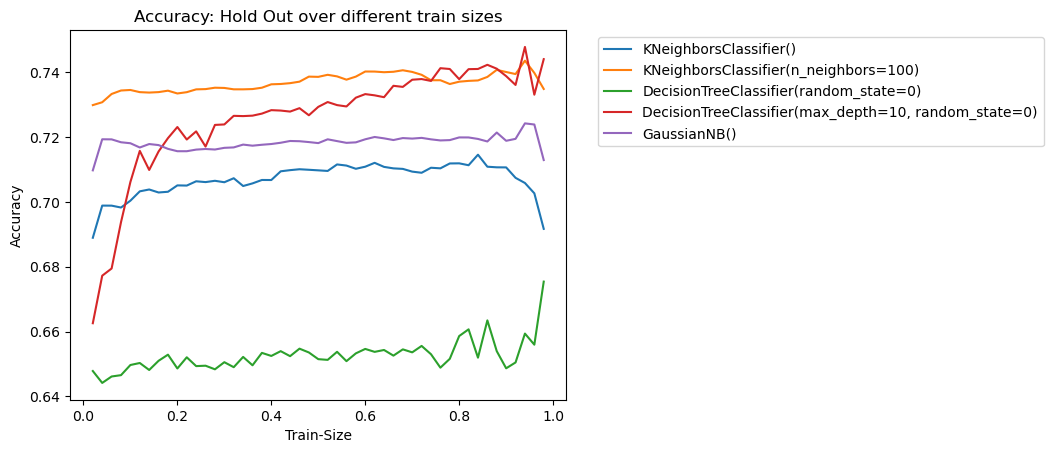

In [287]:
h_out = {}
reps =  [i/50 for i in range(1, 50)]
for i in models:
    ho_list = []
    for j in reps:
        X_train, X_test, y_train, y_test = train_test_split(X, y,  train_size = j, random_state = 1)
        y_pred = i.fit(X_train, y_train).predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        ho_list.append(acc)
    h_out[i] = ho_list
acc_values = pd.DataFrame(h_out, columns = h_out.keys(), index = reps)
acc_values
ax = acc_values.plot()
ax.set_xlabel("Train-Size")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy: Hold Out over different train sizes")
ax.legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

This experiment shows the dependency of training data size to estimate accuracy for decision tree algorithms in hold out testing. 
The other three namely KNN: default and 100 neighbours and gaussian Naive Bayes follow more of a table top trend, meaning the accuracy increases sharply at the beginning with increase in train data size and then plateaus with small deviations and ends by falling down. I am not entirely sure what it tells about the stability of the ranking though. Apart from DT10, others largely follow the Case 1 (HO) trend as seen above. This could suggest that the DT algorithm is able to utilise its max depth condition is a better way upon increase of the training set and thus the generalisation test set accuracy is increasing drastically. The default DT classifier is behaving in almost the same way in all the experiments so far, it seems that DT is highly prone to problems of overfitting and needs pruning conditions.

#### Q3. Reduce the dataset to a random sample of size 3,000 and repeat the two evaluations above. What do these evaluations tell us about the relative merits of cross-validation and hold-out testing?


In [288]:
df = pd.read_csv('diabetes_70k.csv') #since I pop-ed the y before, I am uploading the df again to create a sample
df_sample = df.sample(n=3000, random_state = 1)
df_sample.shape

(3000, 22)

In [289]:
y_ = df_sample.pop('class').values

In [290]:
X_raw = df_sample.values
scaler = StandardScaler()
X_ = scaler.fit_transform(X_raw)
X_.shape

(3000, 21)

In [291]:
for i in models:
    kf = KFold(n_splits=5, shuffle = True, random_state=1) # needed to ensure shuffling
    scores = cross_val_score(i, X_, y_, cv=kf)
    #print(scores)
    print("5 x {0} : {1:.2f}, {2:.4f}".format(i, scores.mean(), scores.std())) 

5 x KNeighborsClassifier() : 0.70, 0.0254
5 x KNeighborsClassifier(n_neighbors=100) : 0.73, 0.0152
5 x DecisionTreeClassifier(random_state=0) : 0.65, 0.0078
5 x DecisionTreeClassifier(max_depth=10, random_state=0) : 0.68, 0.0115
5 x GaussianNB() : 0.72, 0.0212


Apart from the GaussianNB which consistently at 72%, all the other classifiers seem to be underperforming on the sample set. The revised rankings for X-val accuracy scores for the sample set are as follows:
1. kNN(n_neighbours = 100) at 73%
2. GaussianNB with default values at 72%
3. Decision Tree (max_depth=10) at 68%
4. kNN with default values at 70%
5. Decision tree with default values at 65%

Although, there's a 1% decrease in accuracy with kNN classifiers, the conditional decision tree (DT with max_depth: 10) whose accuracy has fallen by 5%. Since, we have reduced the sample size to 3000, it could be that max_depth is too high, overfitting the traning data and reducing the overall accuracy on test data. Another thing to note is that the standard deviations have slightly increased viz-a-viz the full set.

#### Stability Analysis for X-Val accuracy scores across classifiers for the sample set

Repeating the two cases as before:
1. Running the X-Val tests 50 times and shuffling the train and test sets randomly to measure accuracy over these 50 iterations
2. Checking the variation in accuracy for different sizes of folds.

I plot the accuracy graphs of all the 5 classifiers to check the stability trends for the sample set.

#### Case 1

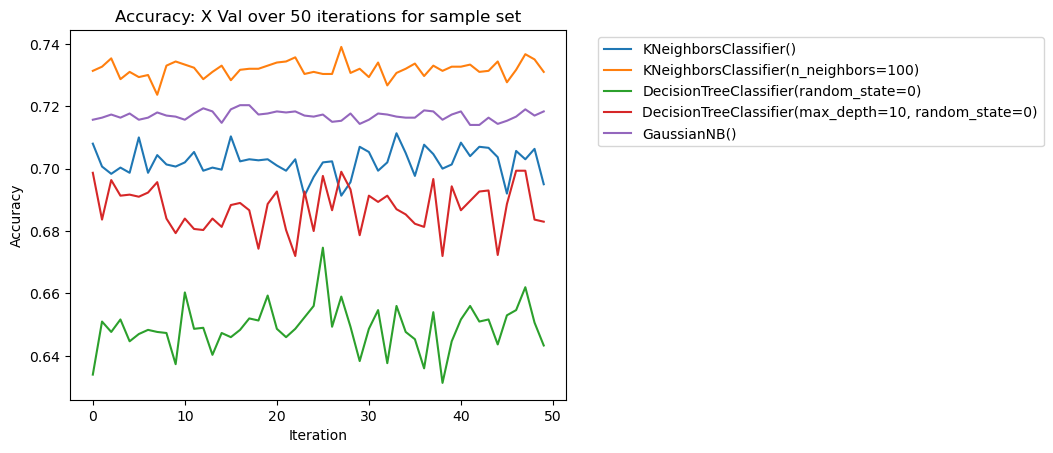

In [292]:
xv3000 = {}
reps = 50  
for i in models:
    xv3000_list = []
    for j in range(reps):
        kf = KFold(n_splits=5, shuffle = True, random_state=j)
        scores = cross_val_score(i, X_, y_, cv=kf)
        xv3000_list.append(scores.mean())
        #print(xv3000_list)
    xv3000[i] = xv3000_list
acc_values3000 = pd.DataFrame(xv3000, columns = xv3000.keys())
acc_values3000
ax = acc_values3000.plot()
ax.set_xlabel("Iteration")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy: X Val over 50 iterations for sample set")
ax.legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

Over 50 iterations, the ranking trend remains consistent with our accuracy score ranks for x-val discussed above. However, there is a significant increase in variance vs Xval full set. I am going to finish all tests to comment on these collectively.

#### Case 2

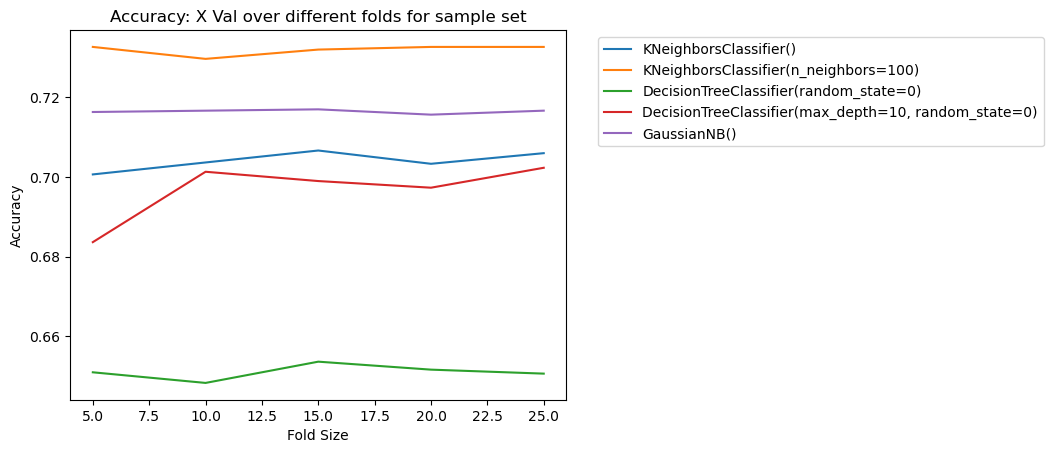

In [293]:
xv = {} 
for i in models:
    xv_list = []
    cv_num = [5, 10, 15, 20, 25]
    for j in cv_num:
        kf = KFold(n_splits=j,shuffle = True, random_state=1)
        scores = cross_val_score(i, X_, y_, cv=kf)   
        xv_list.append(scores.mean())
        #print(xv_list)
    xv[i] = xv_list
acc_values = pd.DataFrame(xv, columns = xv.keys(), index = cv_num)
acc_values
ax = acc_values.plot()
ax.set_xlabel("Fold Size")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy: X Val over different folds for sample set")
ax.legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

It is clear that reducing the size of the set can increase the variance in X-val accuracy scores across iterations as well as when tested for different fold sizes. The accuracy scores for decisiontree with max_depth = 10 is prone to overfitting and loses its accuracy when trained on smaller training sets. 

#### Hold out testing on the sample set accross classifiers

In [294]:
hold_out3000 = {}
for i in models:
    X_train, X_test, y_train, y_test = train_test_split(X_, y_,  train_size = 2/3, random_state = 1)
    y_pred = i.fit(X_train, y_train).predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    hold_out3000[i] = acc
print(hold_out3000)

{KNeighborsClassifier(): 0.696, KNeighborsClassifier(n_neighbors=100): 0.74, DecisionTreeClassifier(random_state=0): 0.673, DecisionTreeClassifier(max_depth=10, random_state=0): 0.665, GaussianNB(): 0.714}


Following is the order of ranking in terms of the accuracy (rounded off) of the given 5 classifiers using hold out testing on the sample set:
1. kNN(n_neighbours = 100) at 74%
2. GaussianNB with default values at 72%
3. kNN with default values at 70%
4. Decision Tree (max_depth=10) at 67%
5. Decision tree with default values at 67%

The order of ranking has changed for HO for the sample set. It would be interesting to check out the stability of these ranking using our two cases.

#### Stability Analysis for Hold-Out accuracy scores across classifiers for the sample set

Repeating the two cases to capture the H-O accuracy trends:
1. Running the HO tests 50 times and shuffling the train and test sets randomly to measure accuracy over these 50 iterations while the split stays 2:1
2. Checking the variation in accuracy for different sizes of train-test splits

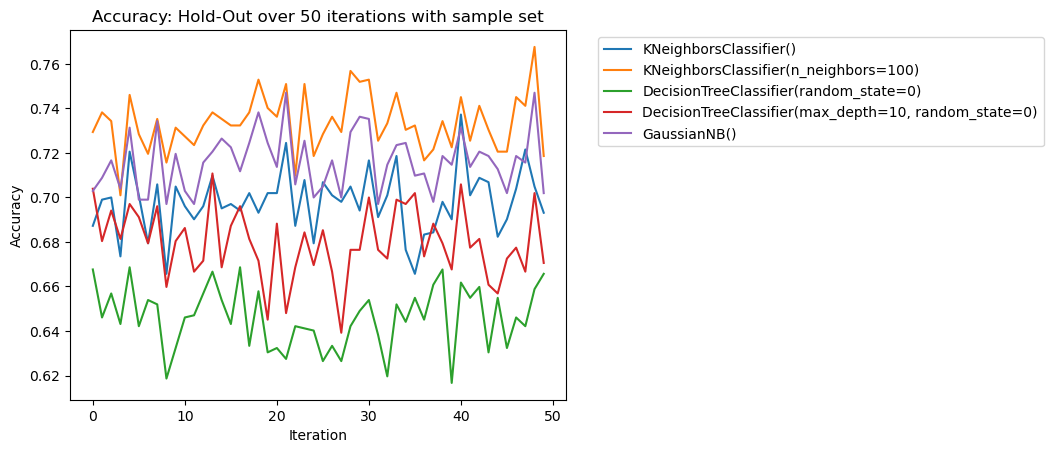

In [295]:
h_out = {}
reps = 50  
for i in models:
    ho_list = []
    for j in range(reps):
        X_train, X_test, y_train, y_test = train_test_split(X_, y_,  train_size = 0.66, random_state=j)
        y_pred = i.fit(X_train, y_train).predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        ho_list.append(acc)
    h_out[i] = ho_list
acc_values = pd.DataFrame(h_out, columns = h_out.keys())
acc_values
ax = acc_values.plot()
ax.set_xlabel("Iteration")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy: Hold-Out over 50 iterations with sample set")
ax.legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Although the ranking order as discussed above is preserved, the variation iteration by iteration is the largest seen so far. 4/5 of the classifiers can hardly be distinguished in some areas (check iteration 5-10, 20-25, 40,  45-50). HO testing doesn't seem to be giving stable results for smaller set. 

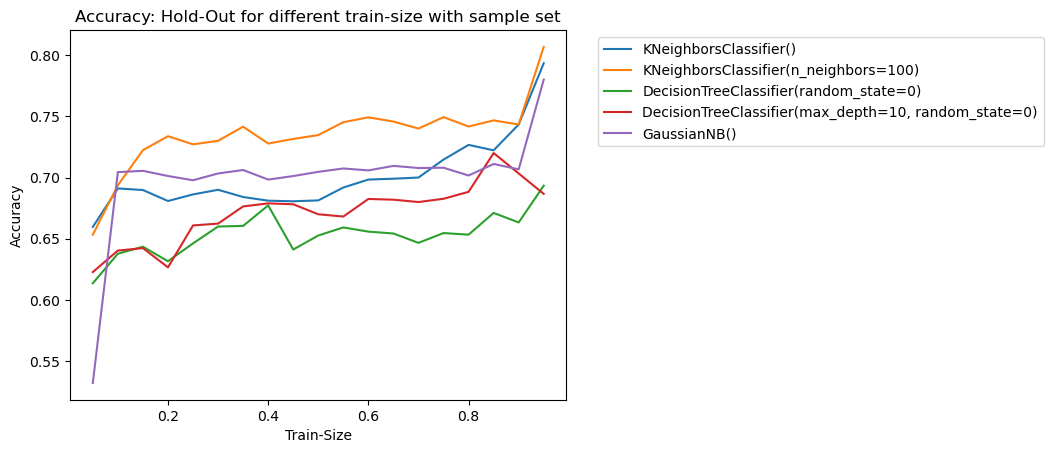

In [296]:
h_out = {}
reps =  [i/20 for i in range(1, 20)] # reducing the size from 50 to 20 as this is the sample set
for i in models:
    ho_list = []
    for j in reps:
        X_train, X_test, y_train, y_test = train_test_split(X_, y_,  train_size = j, random_state = 1)
        y_pred = i.fit(X_train, y_train).predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        ho_list.append(acc)
    h_out[i] = ho_list
acc_values = pd.DataFrame(h_out, columns = h_out.keys(), index = reps)
acc_values
ax = acc_values.plot()
ax.set_xlabel("Train-Size")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy: Hold-Out for different train-size with sample set")
ax.legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Apart from DT10, every classifiers accuracy is increasing sharply (special mention to GNB where its the sharpest) with increase in train size in the beginning, plateau-ing in the middle with some variations and going up in the end. For DT10, the accuracy is gradually increasing with slight variations and dropping in the end confirming our intial discussion that DT needs more data to classify but after an optimum training size, it starts overfitting, which reduces its generalisation accuracy for unseen data.

#### Relative merits of X-val and Hold Out evaluations:
|                       X-val                 |                 Hold Out                 |
|---------------------------------------------|------------------------------------------|
|Rigorous and reliable as it averages out the accuracy over kfolds and reduces the impact of one-odd data-split| Suitable for large datasets were a large test set is good enough for estimating accuracy |
|More suitable for smaller sets vs HO, maximises the use of limited data| Suitable for deploying large models in real time where it will be computationally inefficient to run evaluations ktimes|
|Lower variance in accuracy estimates due to moderating effect of averaging|High variance in smaller datasets because of one split strategy, its simplicity and practicality are best for larger datasets and complex models such as deep learning|


Given the stablity of X-val estimates on sample set, we could explore using X-val for classifier selection for model training using sample set and Hold-Out for reporting metrics for the full set. This would enable us to benefit from the merits of both of these evaluation strategies. 